# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4874 | MulticlassF1Score=0.2039
Batch-30 : CrossEntropyLoss=2.4849 | MulticlassF1Score=0.2371
Batch-45 : CrossEntropyLoss=2.4808 | MulticlassF1Score=0.2698
Batch-60 : CrossEntropyLoss=2.4510 | MulticlassF1Score=0.2915
Batch-75 : CrossEntropyLoss=2.3949 | MulticlassF1Score=0.3224
Batch-90 : CrossEntropyLoss=2.3964 | MulticlassF1Score=0.3469
Batch-105: CrossEntropyLoss=2.4173 | MulticlassF1Score=0.3670
Batch-120: CrossEntropyLoss=2.3797 | MulticlassF1Score=0.3854
Batch-135: CrossEntropyLoss=2.3842 | MulticlassF1Score=0.4070
Batch-150: CrossEntropyLoss=2.3807 | MulticlassF1Score=0.4261
Batch-165: CrossEntropyLoss=2.3921 | MulticlassF1Score=0.4430
Batch-180: CrossEntropyLoss=2.3631 | MulticlassF1Score=0.4613
Batch-195: CrossEntropyLoss=2.3464 | MulticlassF1Score=0.4778
Batch-210: CrossEntropyLoss=2.3456 | MulticlassF1Score=0.4912
Batch-225: CrossEntropyLoss=2.3429 | MulticlassF1Score=0.5049
Batch-226: CrossEntropyLoss=2.3426 | MulticlassF1Score=0.5055

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3508 | MulticlassF1Score=0.7310
Batch-30 : CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7339
Batch-45 : CrossEntropyLoss=2.3329 | MulticlassF1Score=0.7293
Batch-60 : CrossEntropyLoss=2.3469 | MulticlassF1Score=0.7282
Batch-63 : CrossEntropyLoss=2.3296 | MulticlassF1Score=0.7285

Training   : Mean CrossEntropyLoss = 2.4127 | Mean MulticlassF1Score = 0.3647
Validation : Mean CrossEntropyLoss = 2.3351 | Mean MulticlassF1Score = 0.7311

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3318 | MulticlassF1Score=0.7359
Batch-30 : CrossEntropyLoss=2.3414 | MulticlassF1Score=0.7365
Batch-45 : CrossEntropyLoss=2.3344 | MulticlassF1Score=0.7365
Batch-60 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7458
Batch-75 : CrossEntropyLoss=2.3240 | MulticlassF1Score=0.7524
Batch-90 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7568
Batch-105: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7609
Batch-120: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.7640
Batch-135: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7670
Batch-150: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7685
Batch-165: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.7710
Batch-180: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7727
Batch-195: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7741
Batch-210: CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7752
Batch-225: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7763
Batch-226: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.7763

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7948
Batch-30 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7934
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7922
Batch-60 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7913
Batch-63 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7916

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3182 | Mean MulticlassF1Score = 0.7582
Validation : Mean CrossEntropyLoss = 2.3128 | Mean MulticlassF1Score = 0.7929

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7946
Batch-30 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8016
Batch-45 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8076
Batch-60 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8086
Batch-75 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8105
Batch-90 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8107
Batch-105: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8112
Batch-120: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8104
Batch-135: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8107
Batch-150: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8117
Batch-165: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8121
Batch-180: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8123
Batch-195: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8124
Batch-210: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8122
Batch-225: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8126
Batch-226: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8126

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8263
Batch-30 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8253
Batch-45 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8259
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8255
Batch-63 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3063 | Mean MulticlassF1Score = 0.8086
Validation : Mean CrossEntropyLoss = 2.3025 | Mean MulticlassF1Score = 0.8269

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8323
Batch-30 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8305
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8316
Batch-60 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8313
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8306
Batch-90 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8294
Batch-105: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8283
Batch-120: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8280
Batch-135: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8282
Batch-150: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8290
Batch-165: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8295
Batch-180: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8301
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8304
Batch-210: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8308
Batch-225: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8315
Batch-226: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8305
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8349
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8353
Batch-63 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8306
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8327

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8332
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8334
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8342
Batch-60 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8345
Batch-75 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8350
Batch-90 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8352
Batch-105: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8364
Batch-120: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8371
Batch-135: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8370
Batch-150: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8371
Batch-165: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8371
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8376
Batch-195: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8378
Batch-210: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8384
Batch-225: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8388
Batch-226: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8399
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8387
Batch-45 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8386
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8377
Batch-63 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8362
Validation : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8382

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8419
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8427
Batch-45 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8429
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8437
Batch-75 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8428
Batch-90 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8430
Batch-105: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8433
Batch-120: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8430
Batch-135: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8429
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8427
Batch-165: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8423
Batch-180: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8418
Batch-195: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8416
Batch-210: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8412
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8413
Batch-226: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8394
Batch-30 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8376
Batch-45 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8392
Batch-60 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8385
Batch-63 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2970 | Mean MulticlassF1Score = 0.8425
Validation : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8394

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8466
Batch-30 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8468
Batch-45 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8449
Batch-60 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8444
Batch-75 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8459
Batch-90 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8450
Batch-105: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8451
Batch-120: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8449
Batch-135: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8452
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8457
Batch-165: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8467
Batch-180: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8474
Batch-195: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8478
Batch-210: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8490
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8504
Batch-226: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8775
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8776
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8769
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8757
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8754

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2942 | Mean MulticlassF1Score = 0.8466
Validation : Mean CrossEntropyLoss = 2.2869 | Mean MulticlassF1Score = 0.8763

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8818
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8815
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8836
Batch-75 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8836
Batch-90 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8838
Batch-105: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8835
Batch-120: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8834
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8831
Batch-150: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8835
Batch-165: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8837
Batch-180: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8840
Batch-195: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8848
Batch-210: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8849
Batch-225: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8852
Batch-226: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8851

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8851
Batch-30 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8834
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8844
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8841
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8841

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8831
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8835

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8843
Batch-30 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8886
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8889
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8906
Batch-75 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8904
Batch-90 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8900
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8898
Batch-120: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8902
Batch-135: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8895
Batch-150: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8895
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8898
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8903
Batch-195: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8904
Batch-210: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8901
Batch-225: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8899
Batch-226: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8899

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8827
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8836
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8856
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8855

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8895
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8840

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8909
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8907
Batch-75 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8914
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8922
Batch-105: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8916
Batch-120: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8918
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8922
Batch-150: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8925
Batch-165: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8925
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8924
Batch-195: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8925
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8926
Batch-225: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8928
Batch-226: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8928

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8837
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8856
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8867
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8917
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8855

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8938
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8932
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8937
Batch-60 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8945
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8945
Batch-90 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8947
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8950
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8949
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8951
Batch-150: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8951
Batch-165: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8952
Batch-180: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8952
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8950
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8948
Batch-225: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8948
Batch-226: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8948

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8862
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8876
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8889

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8948
Validation : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8880

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9021
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8986
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8967
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8972
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8965
Batch-90 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8961
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8962
Batch-120: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8977
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9001
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9022
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9038
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9048
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9057
Batch-210: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9064
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9081
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9081

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9154
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9141
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9138

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9010
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9145

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9213
Batch-75 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9214
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9218
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9224
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9224
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9228
Batch-150: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9227
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9232
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9234
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9238
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9241
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9242
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9242

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9159
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9158

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9220
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9143

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9287
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9287
Batch-90 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9285
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9273
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9273
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9269
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9269
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9268
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9265
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9264
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9263
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9264
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9264

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9143
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9161
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9166
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9168
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9170

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9281
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9154

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9268
Batch-75 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9261
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9263
Batch-105: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9267
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9278
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9282
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9280
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9279
Batch-195: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9275
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9273
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9273
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9273

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9186
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9168
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9172

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9275
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9180

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9294
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9287
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9286
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9282
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9282
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9286
Batch-180: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9286
Batch-195: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9286
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9282
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9282

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9186
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9181
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9182
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9174

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9281
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9182

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9290
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9281
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9290
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9296
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9292
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9295
Batch-165: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9295
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9291
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9291
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9289

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9166
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9180
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9178

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9288
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9156

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9300
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9300
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9295
Batch-105: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9304
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9303
Batch-135: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9308
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9306
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9309
Batch-180: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9299
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9185

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9299
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9192

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9320
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9321
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9311
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9314
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9313
Batch-135: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9310
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9307
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9304
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9304
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9304
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9150
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9175
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9177

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9312
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9164

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9344
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9335
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9333
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9323
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9321
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9320
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9325
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9317
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9318
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9313
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9316
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9316
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9316

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9196
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9322
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9185

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9343
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9353
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9356
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9356
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9353
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9353
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9349
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9345
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9344
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9344
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9346
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9346

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9346
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9205

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9369
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9372
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9370
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9370
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9366
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9364
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9363
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9360
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9359
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9359

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9216
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9264

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9366
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9361
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9368
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9366
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9371
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9371
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9212

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9383
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9376
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9379
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9381
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9379
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9382
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9253

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9373
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9373
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9378
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9382
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9383
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9228

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9391
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9392
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9398
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9205

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9398
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9402
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9230

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9401
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9406
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9403
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9400
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9398
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9399
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9399

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9224

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9407
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9409
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9414
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9247
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9236

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9443
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9249

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9433
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9290
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9278

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9451
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9450
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9248

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9269

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9474
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9459
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9301

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9462
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9462
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9251

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9512
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9532
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9553
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9569
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9584
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9591
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9601
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9606
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9613
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9546
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9483

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9494

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9483

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9495

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9492

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9724
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2511 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2510 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9487

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9652
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9645
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9634
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9631
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9446

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9449
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9638
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9636
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9640
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9478

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9486

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9509

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9478

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9729
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9733
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9718
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9520
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9503

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9712
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9496

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9745
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9747
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9735
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9495

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9734
Batch-30 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9725
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9729
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9723
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9722
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9480

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9722
Best MulticlassF1Score validation : 0.9480
Training duration                 : 2.7771 minutes.
Training date                     : 2022-10-19 14:52:59.508408+08:00


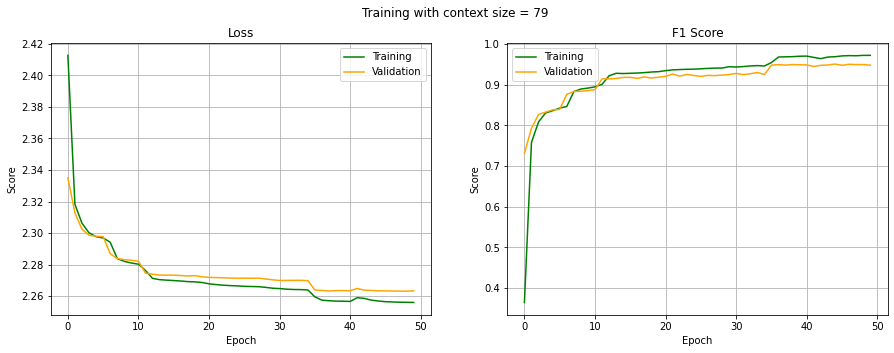

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9719, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9451, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9719, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9451, device='cuda:0'))

## Heatmap

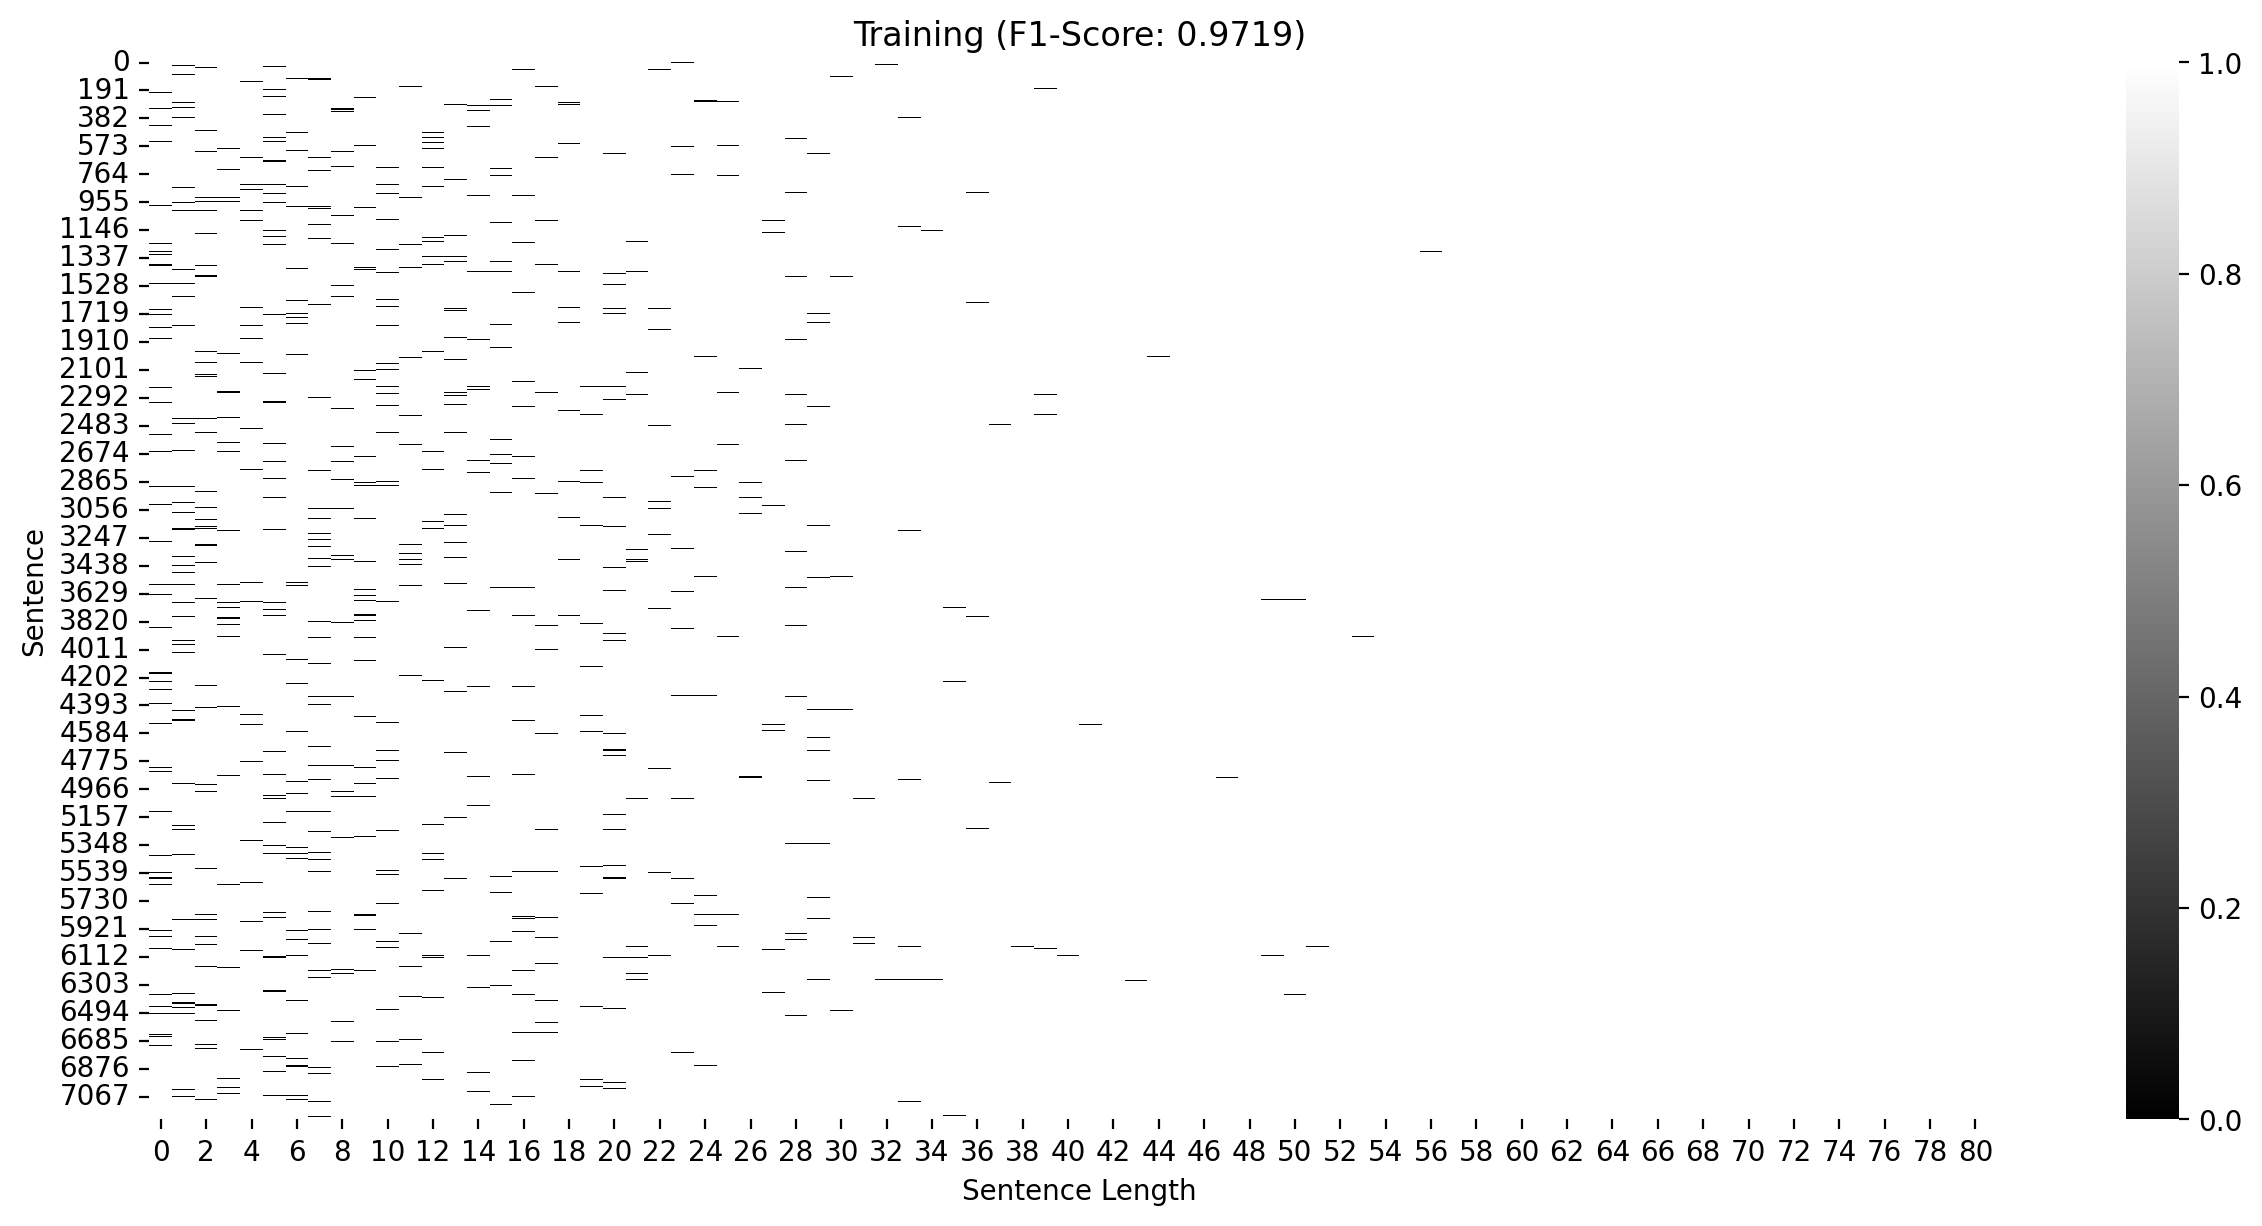

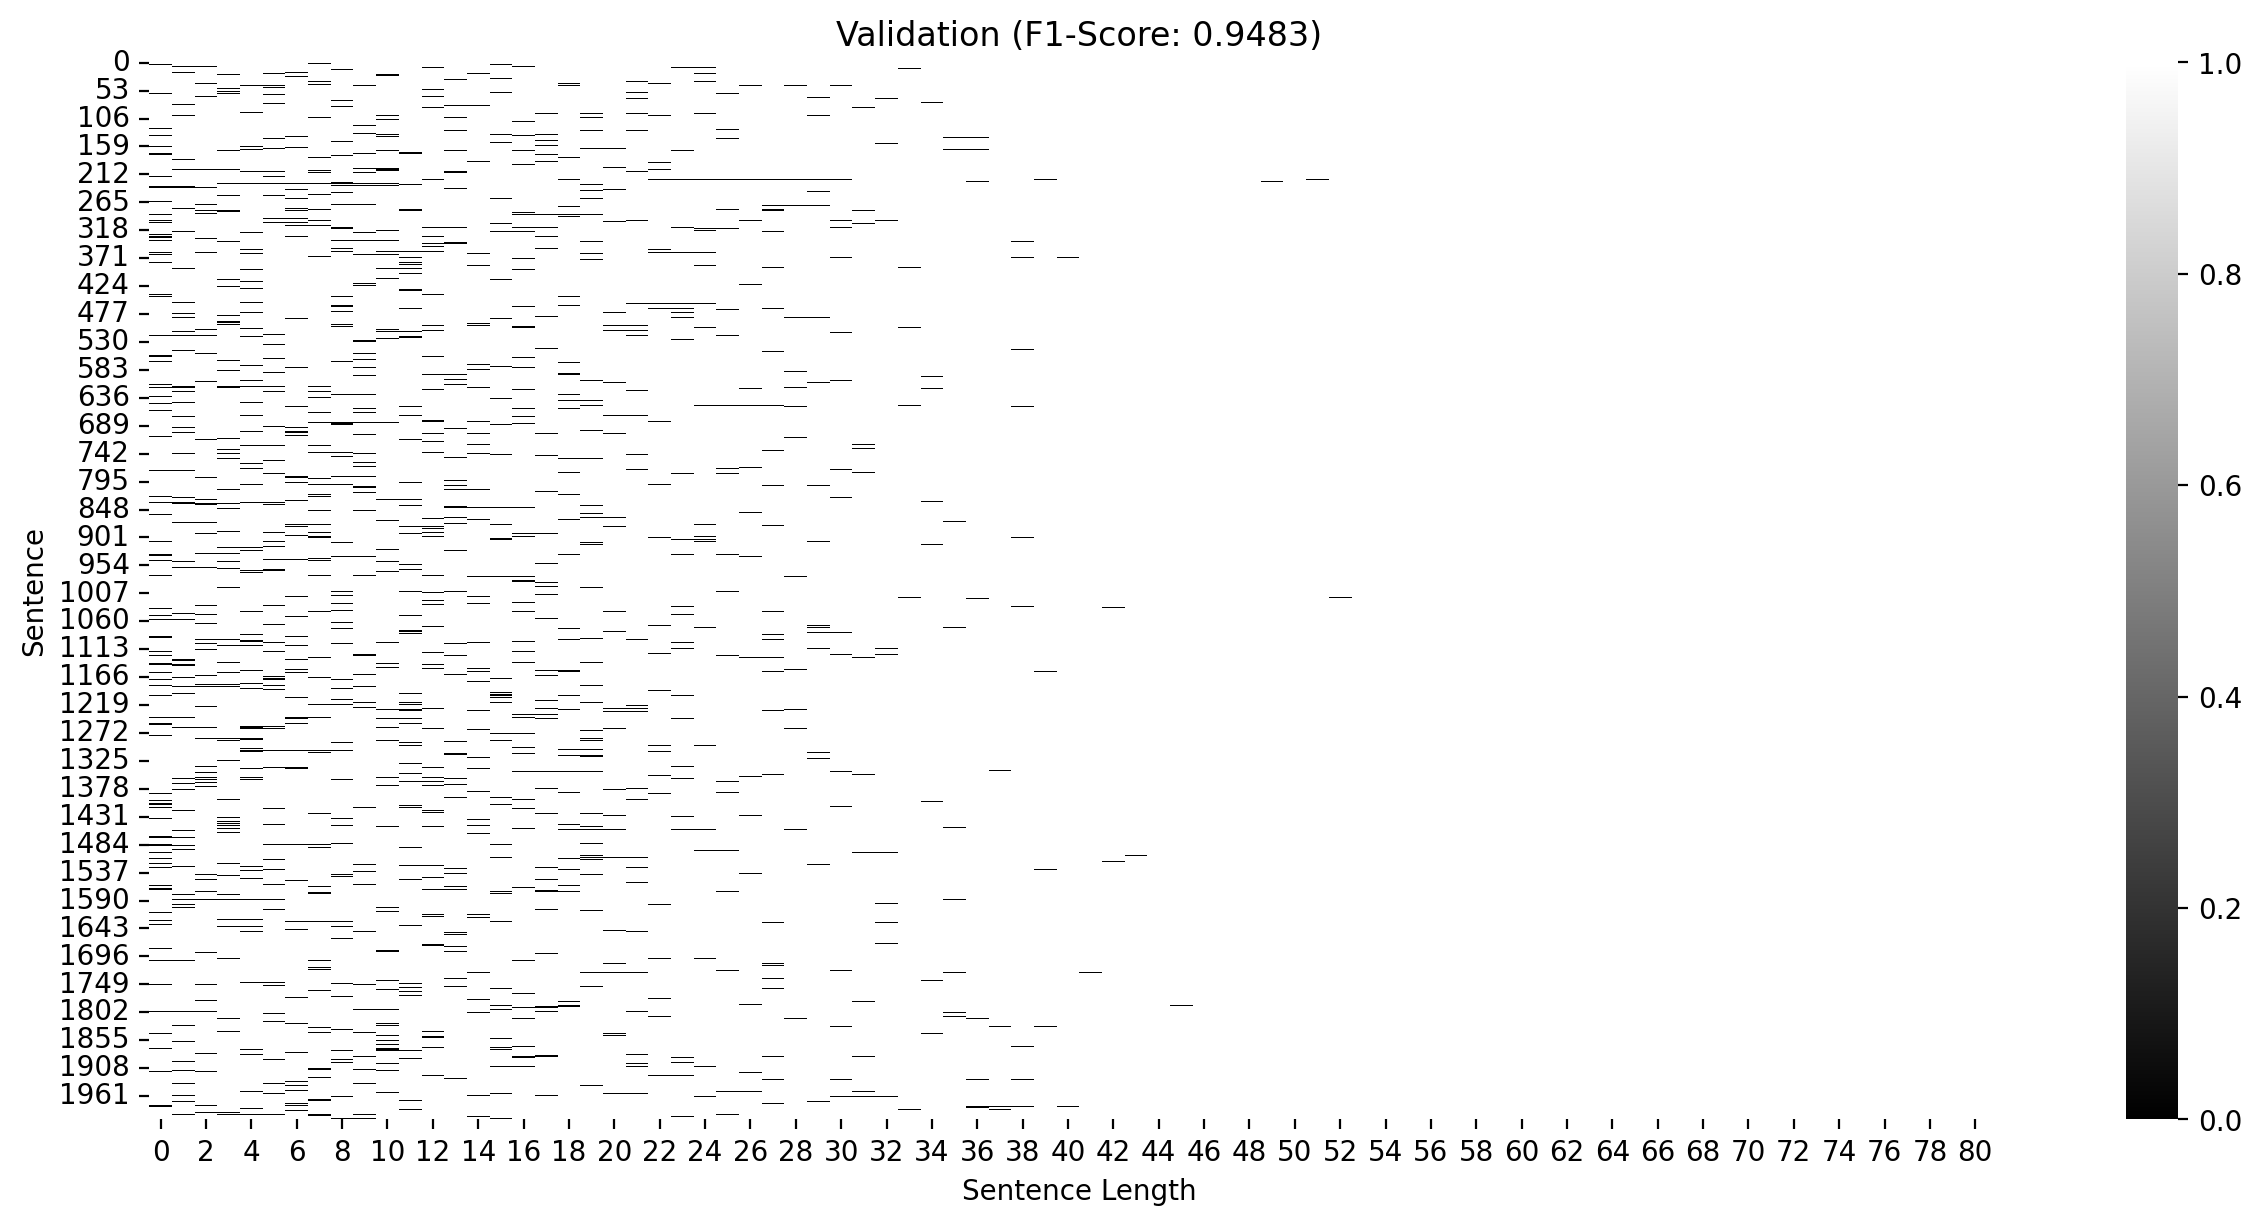

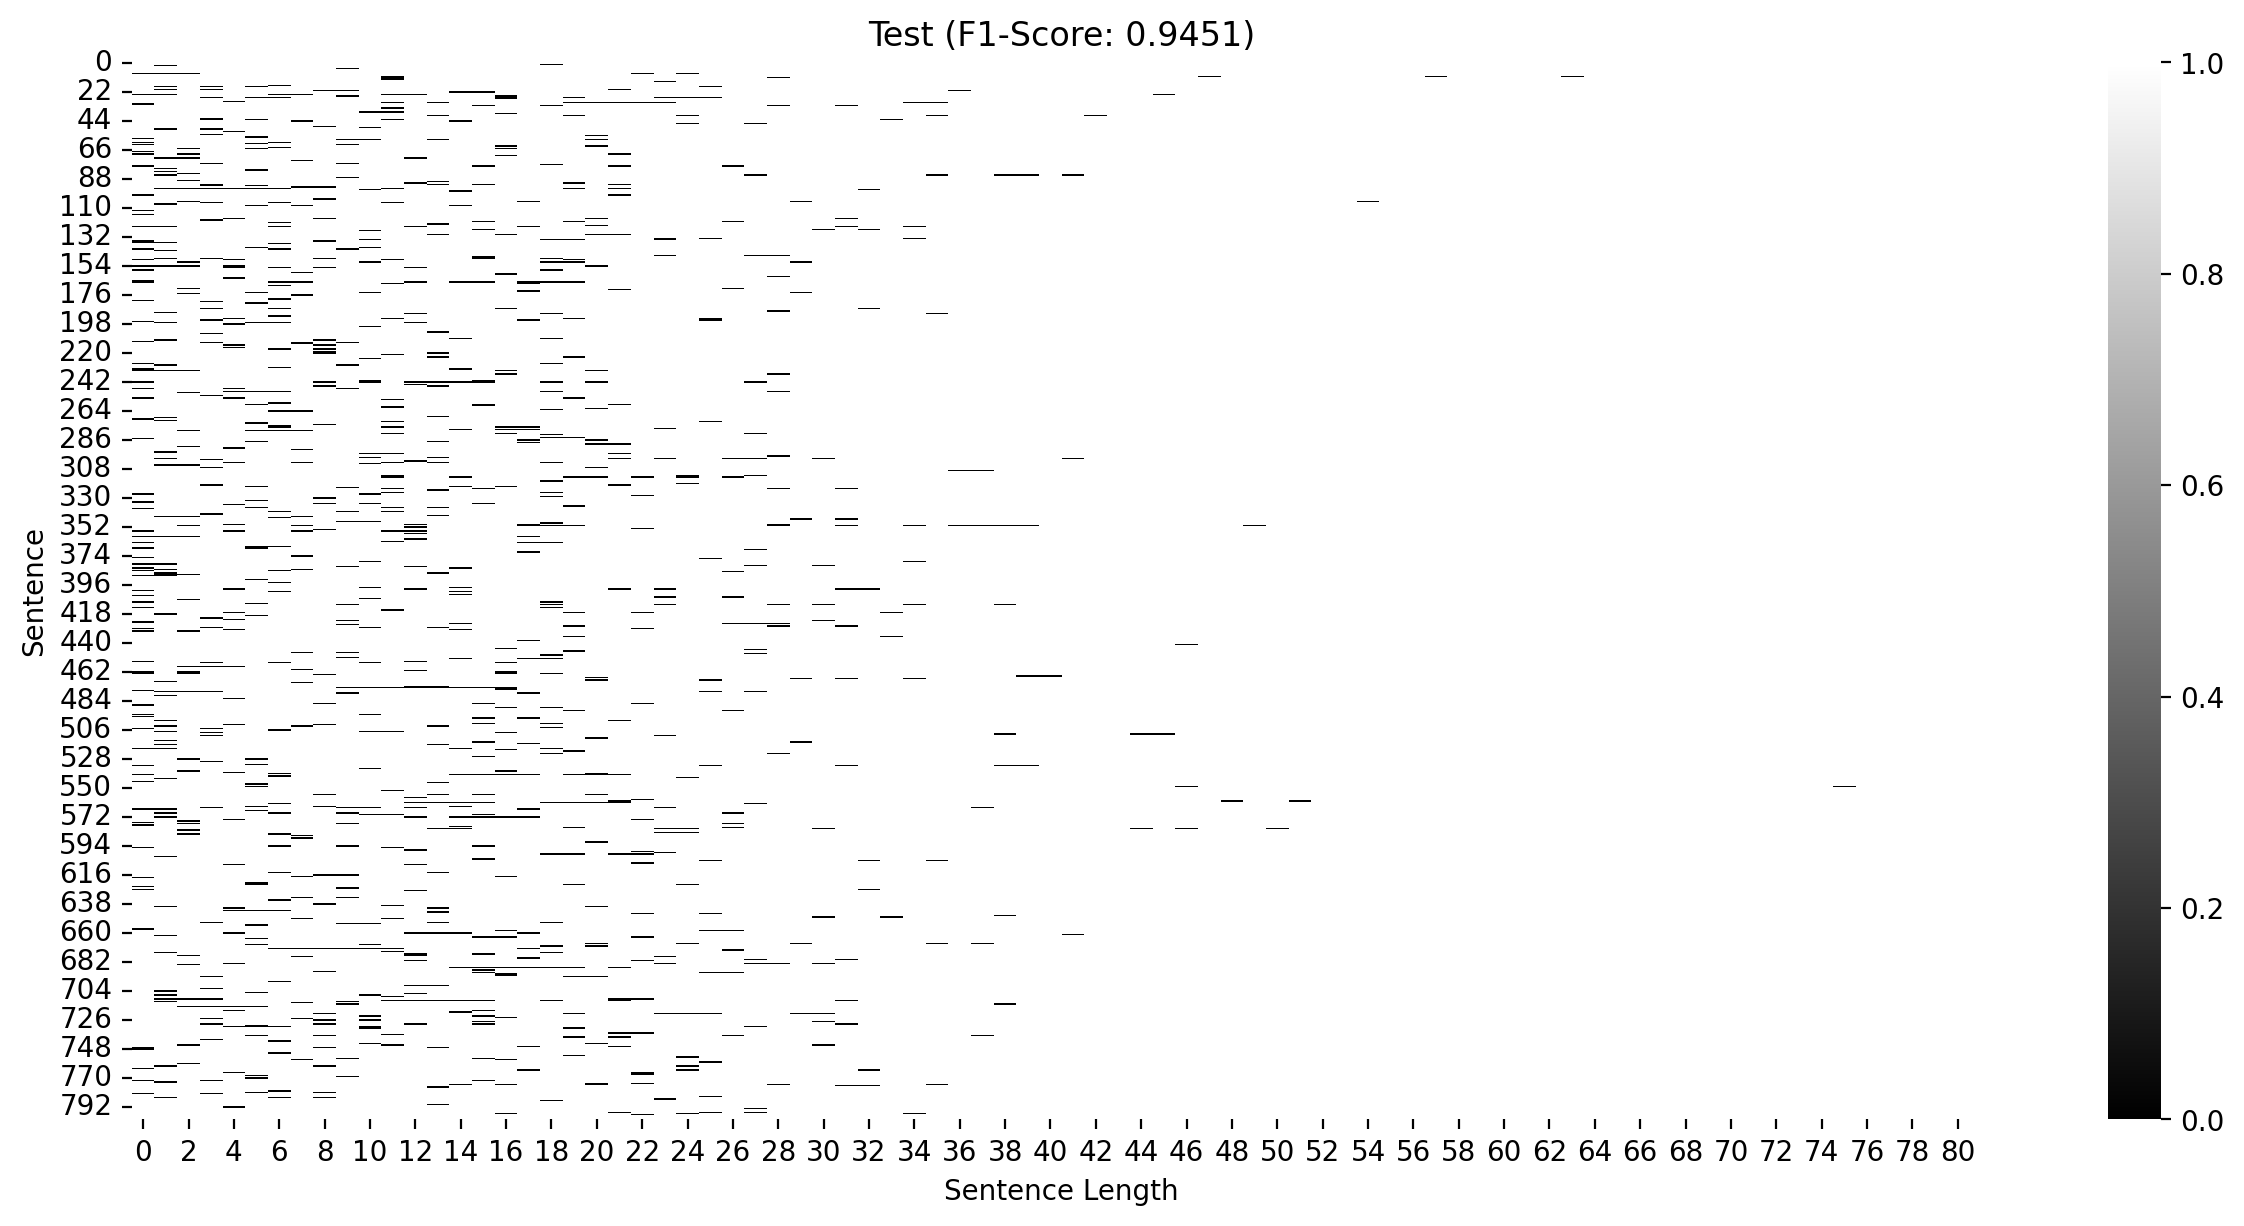

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


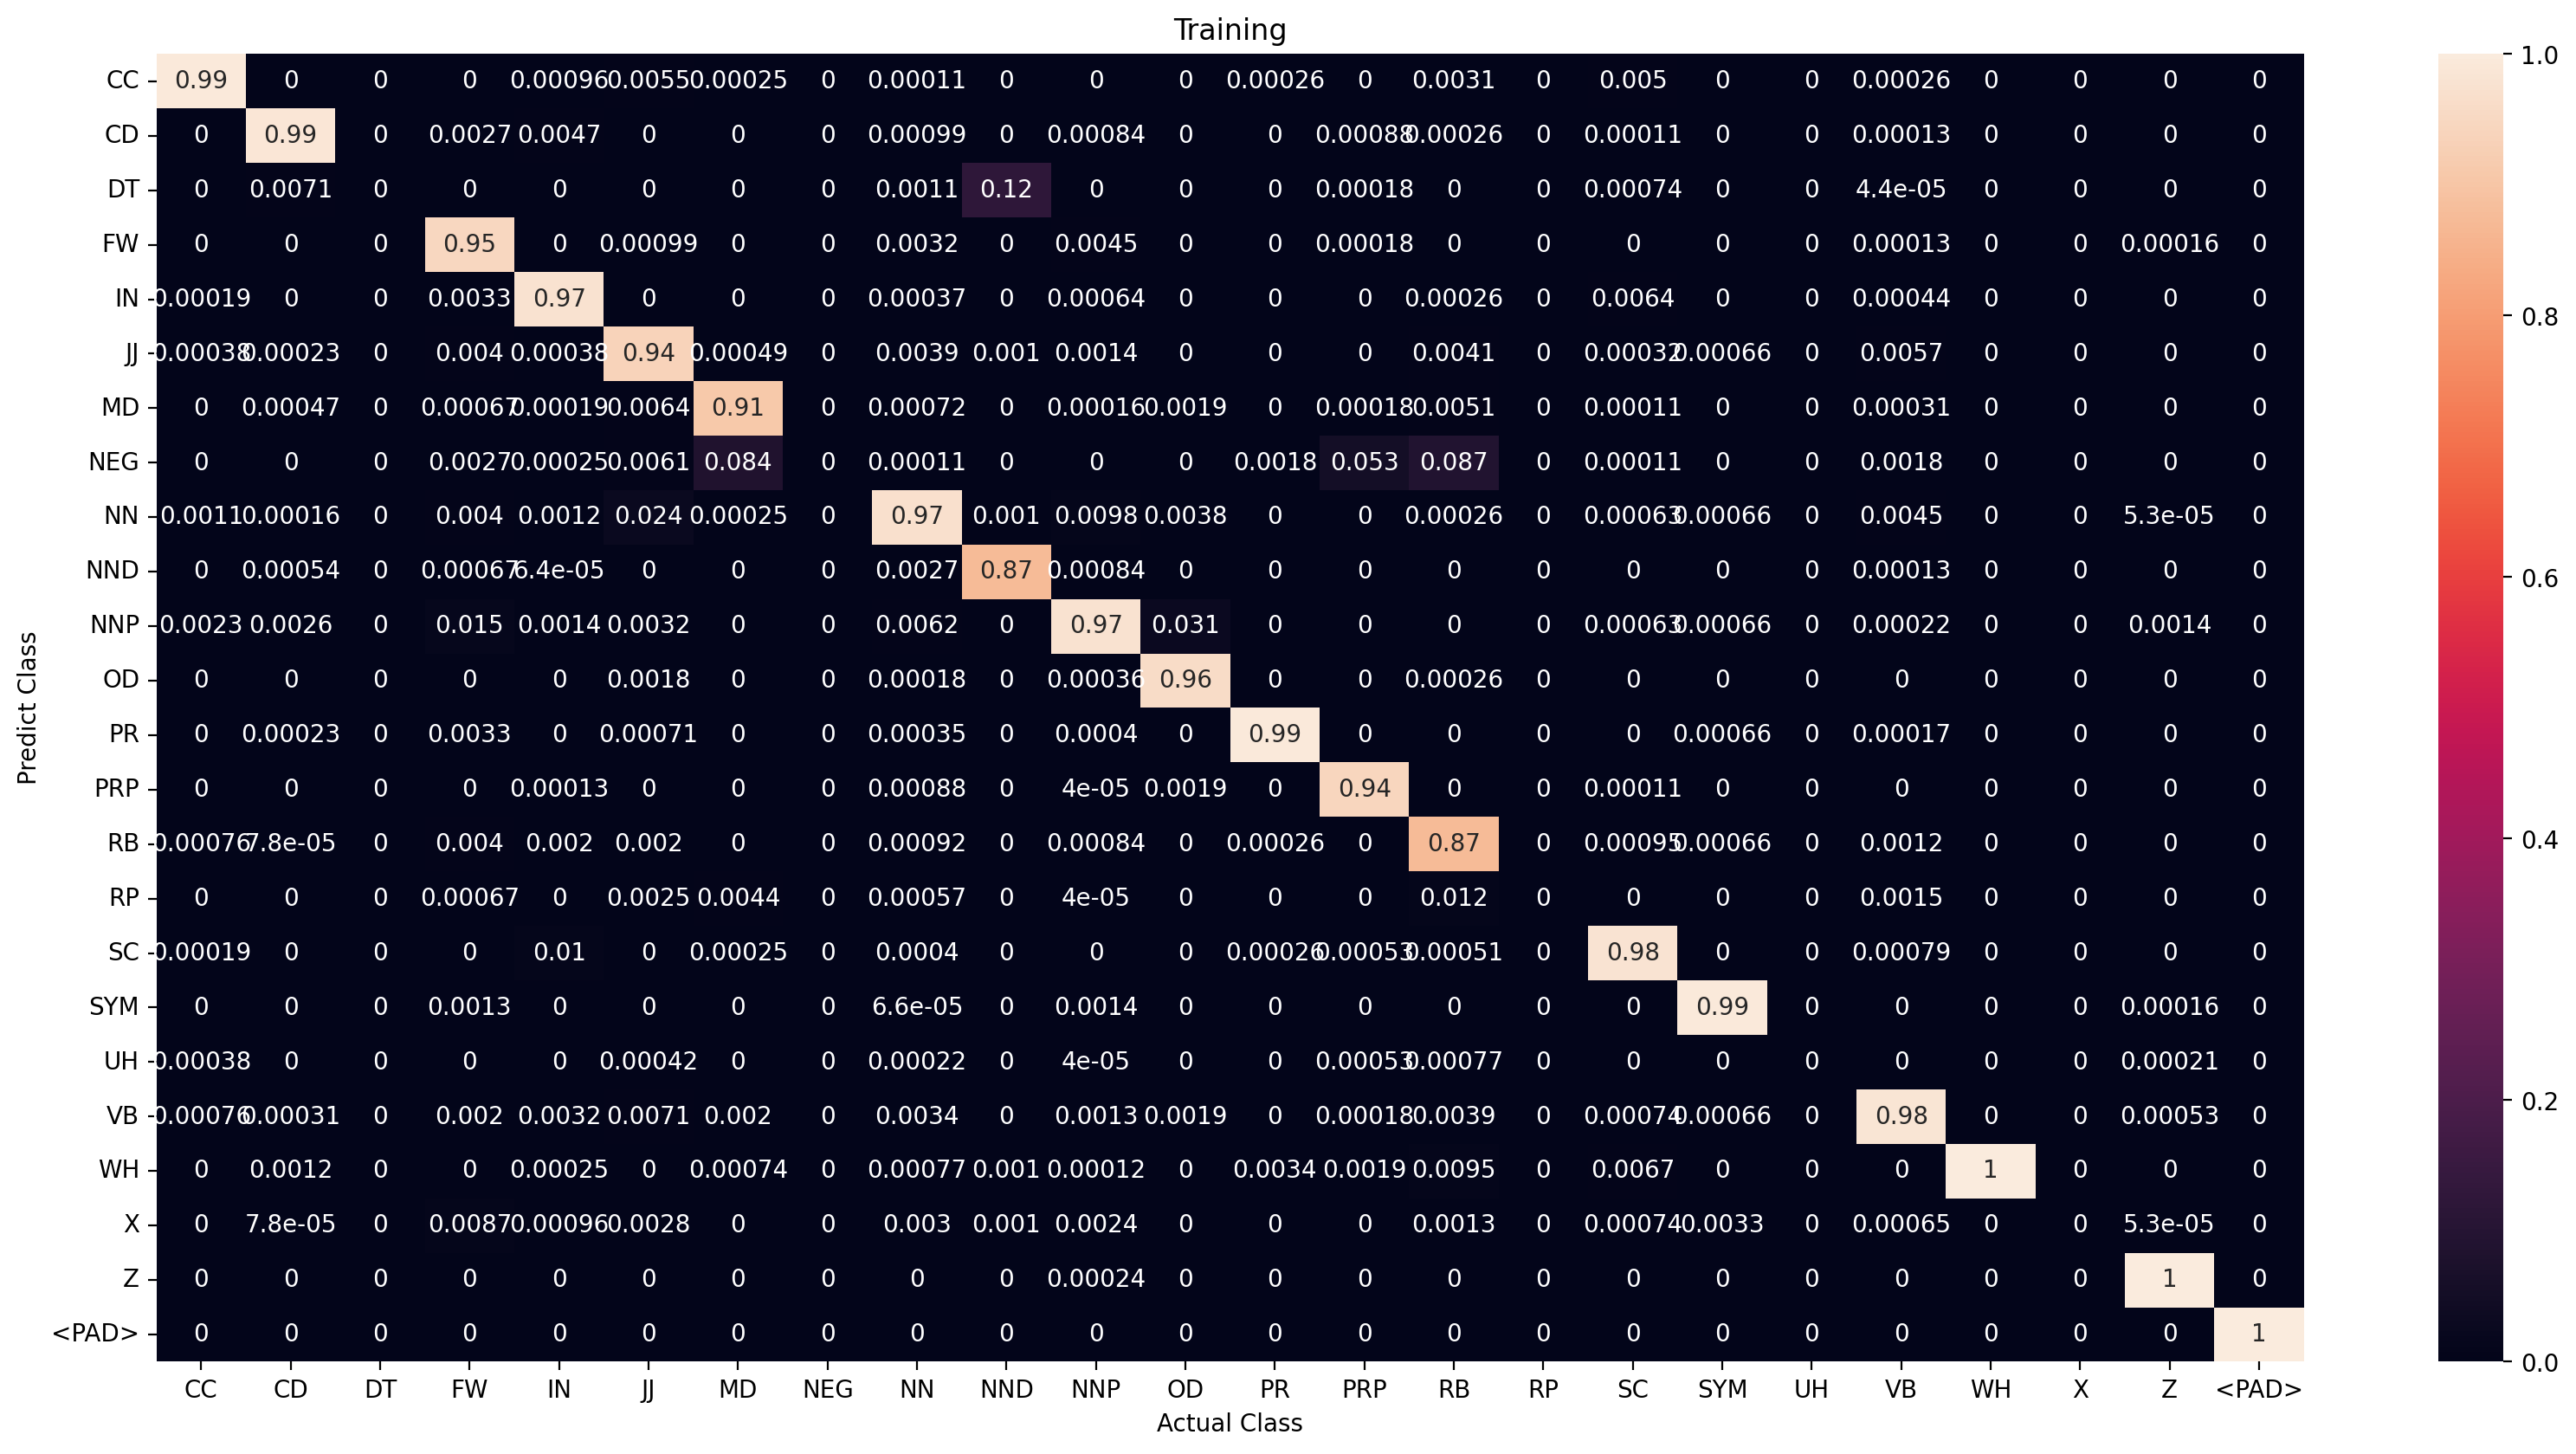

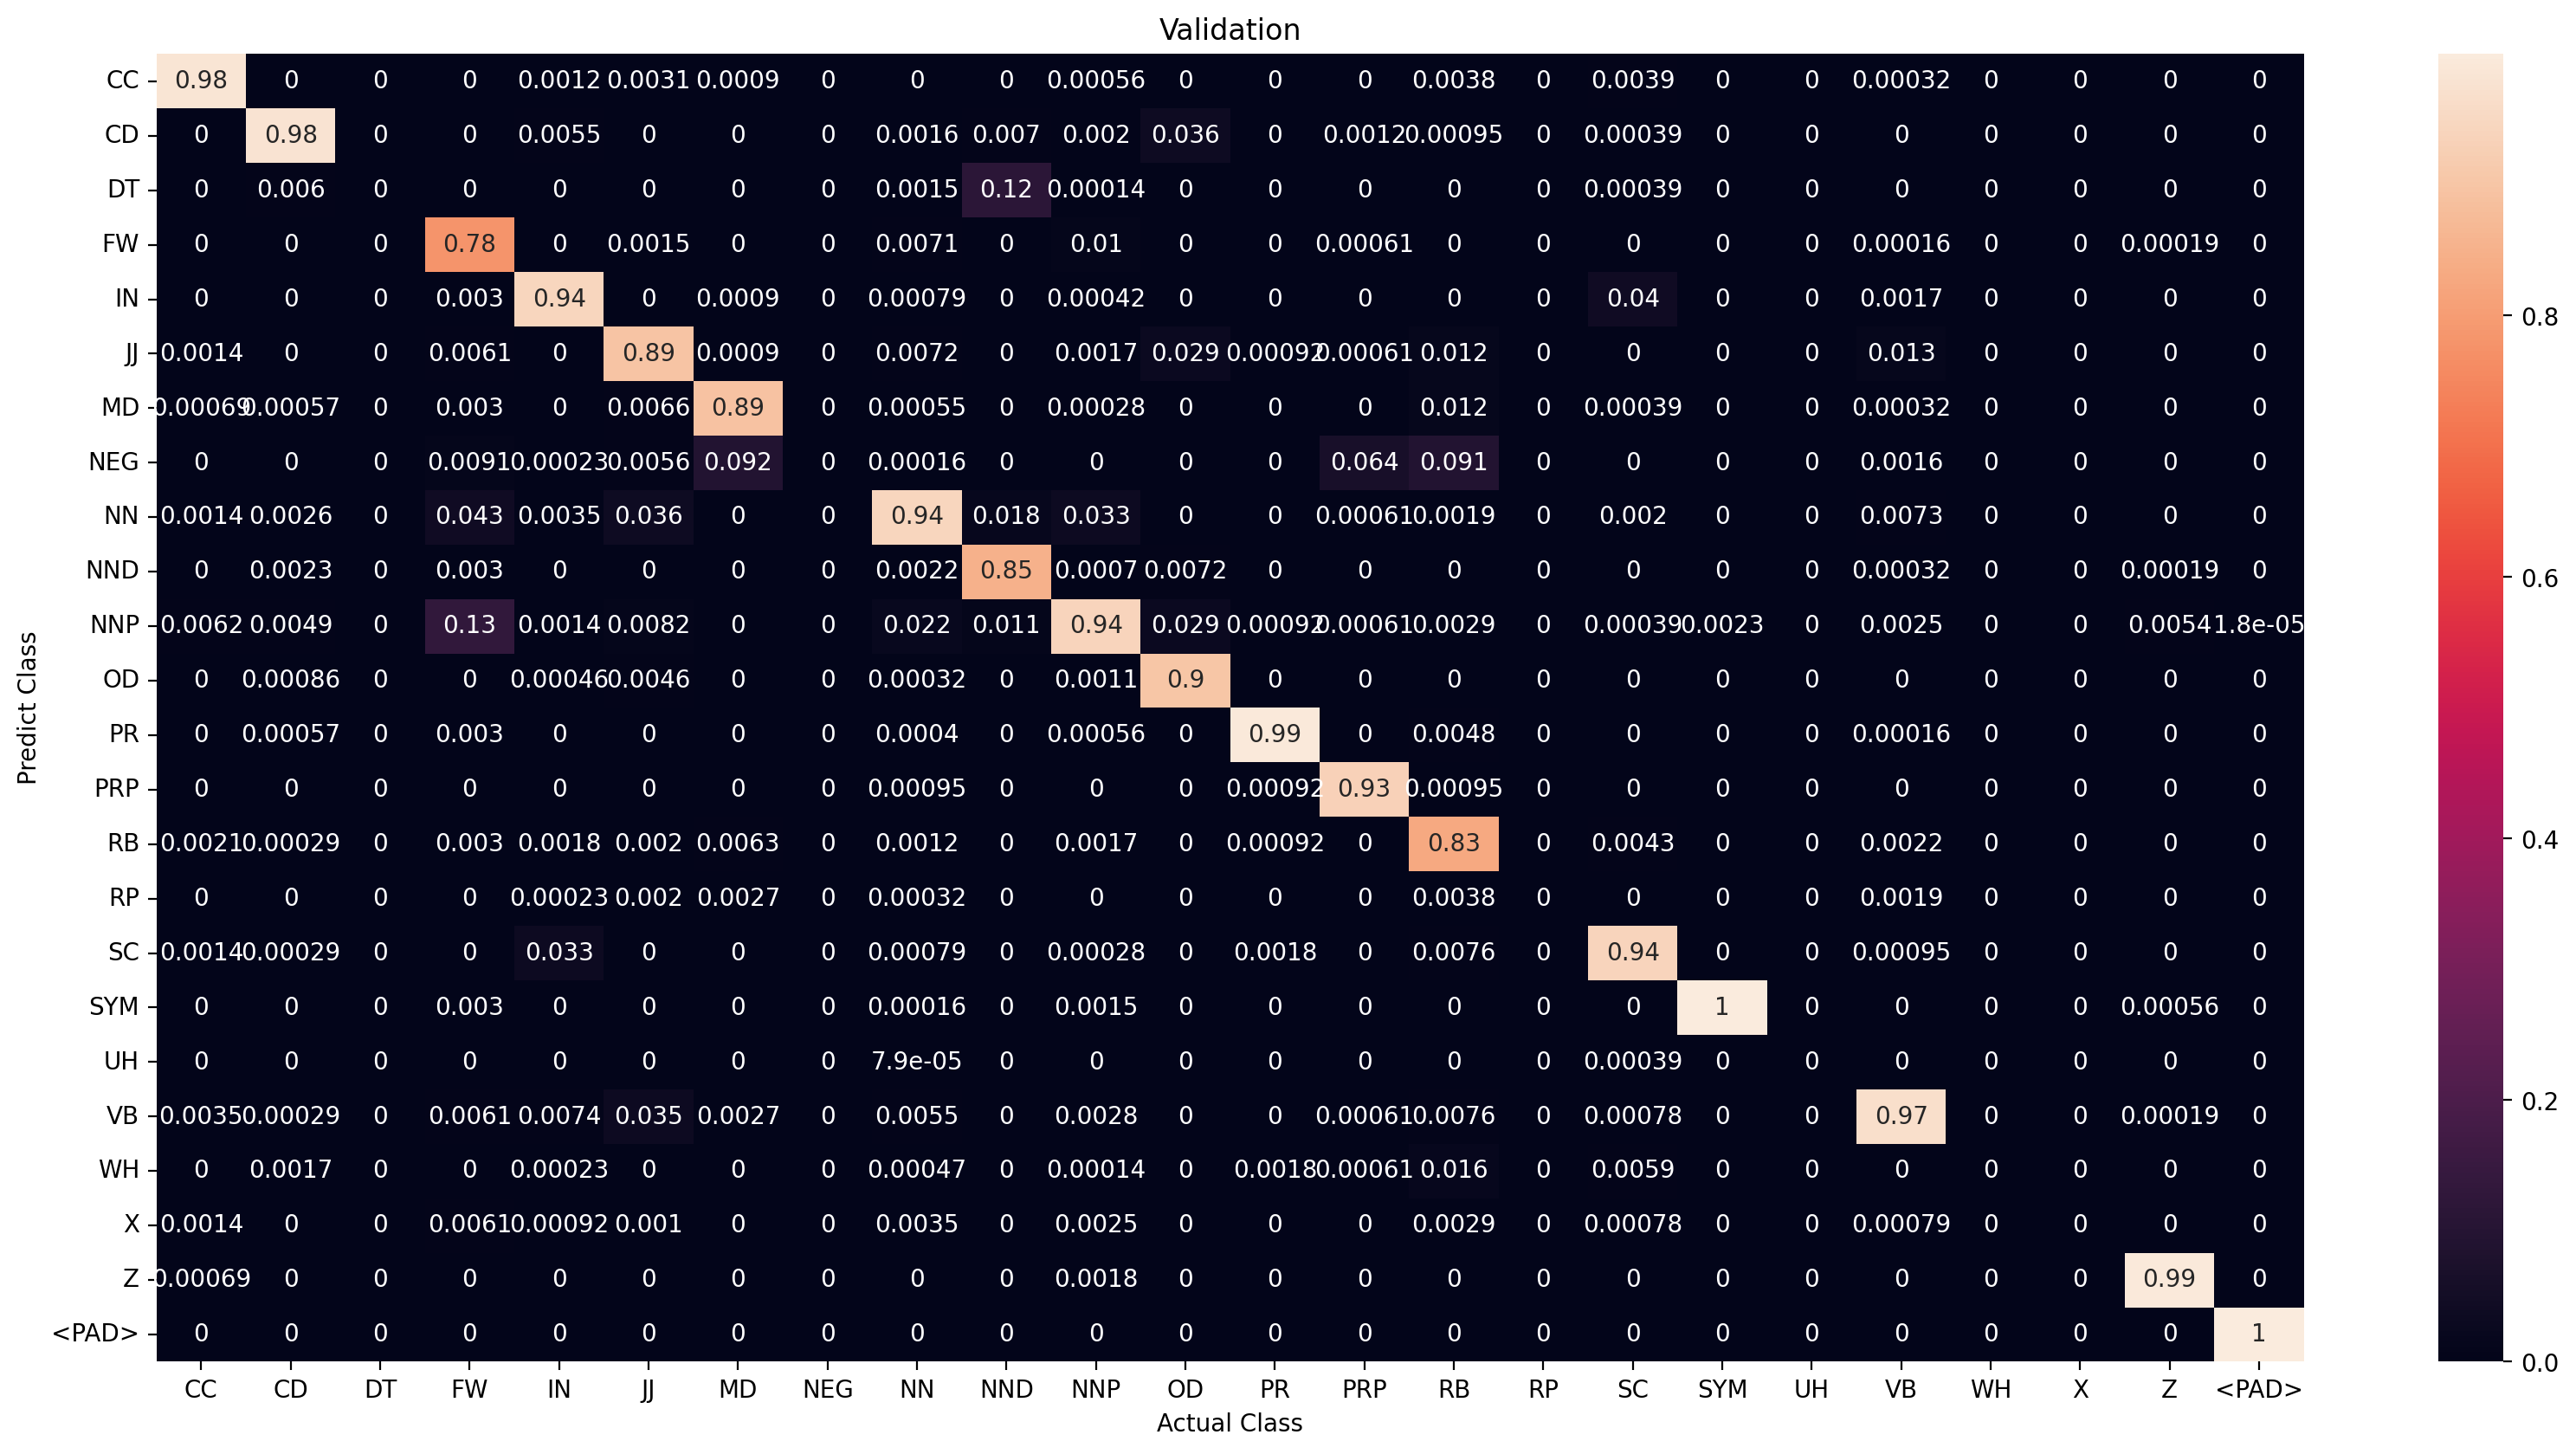

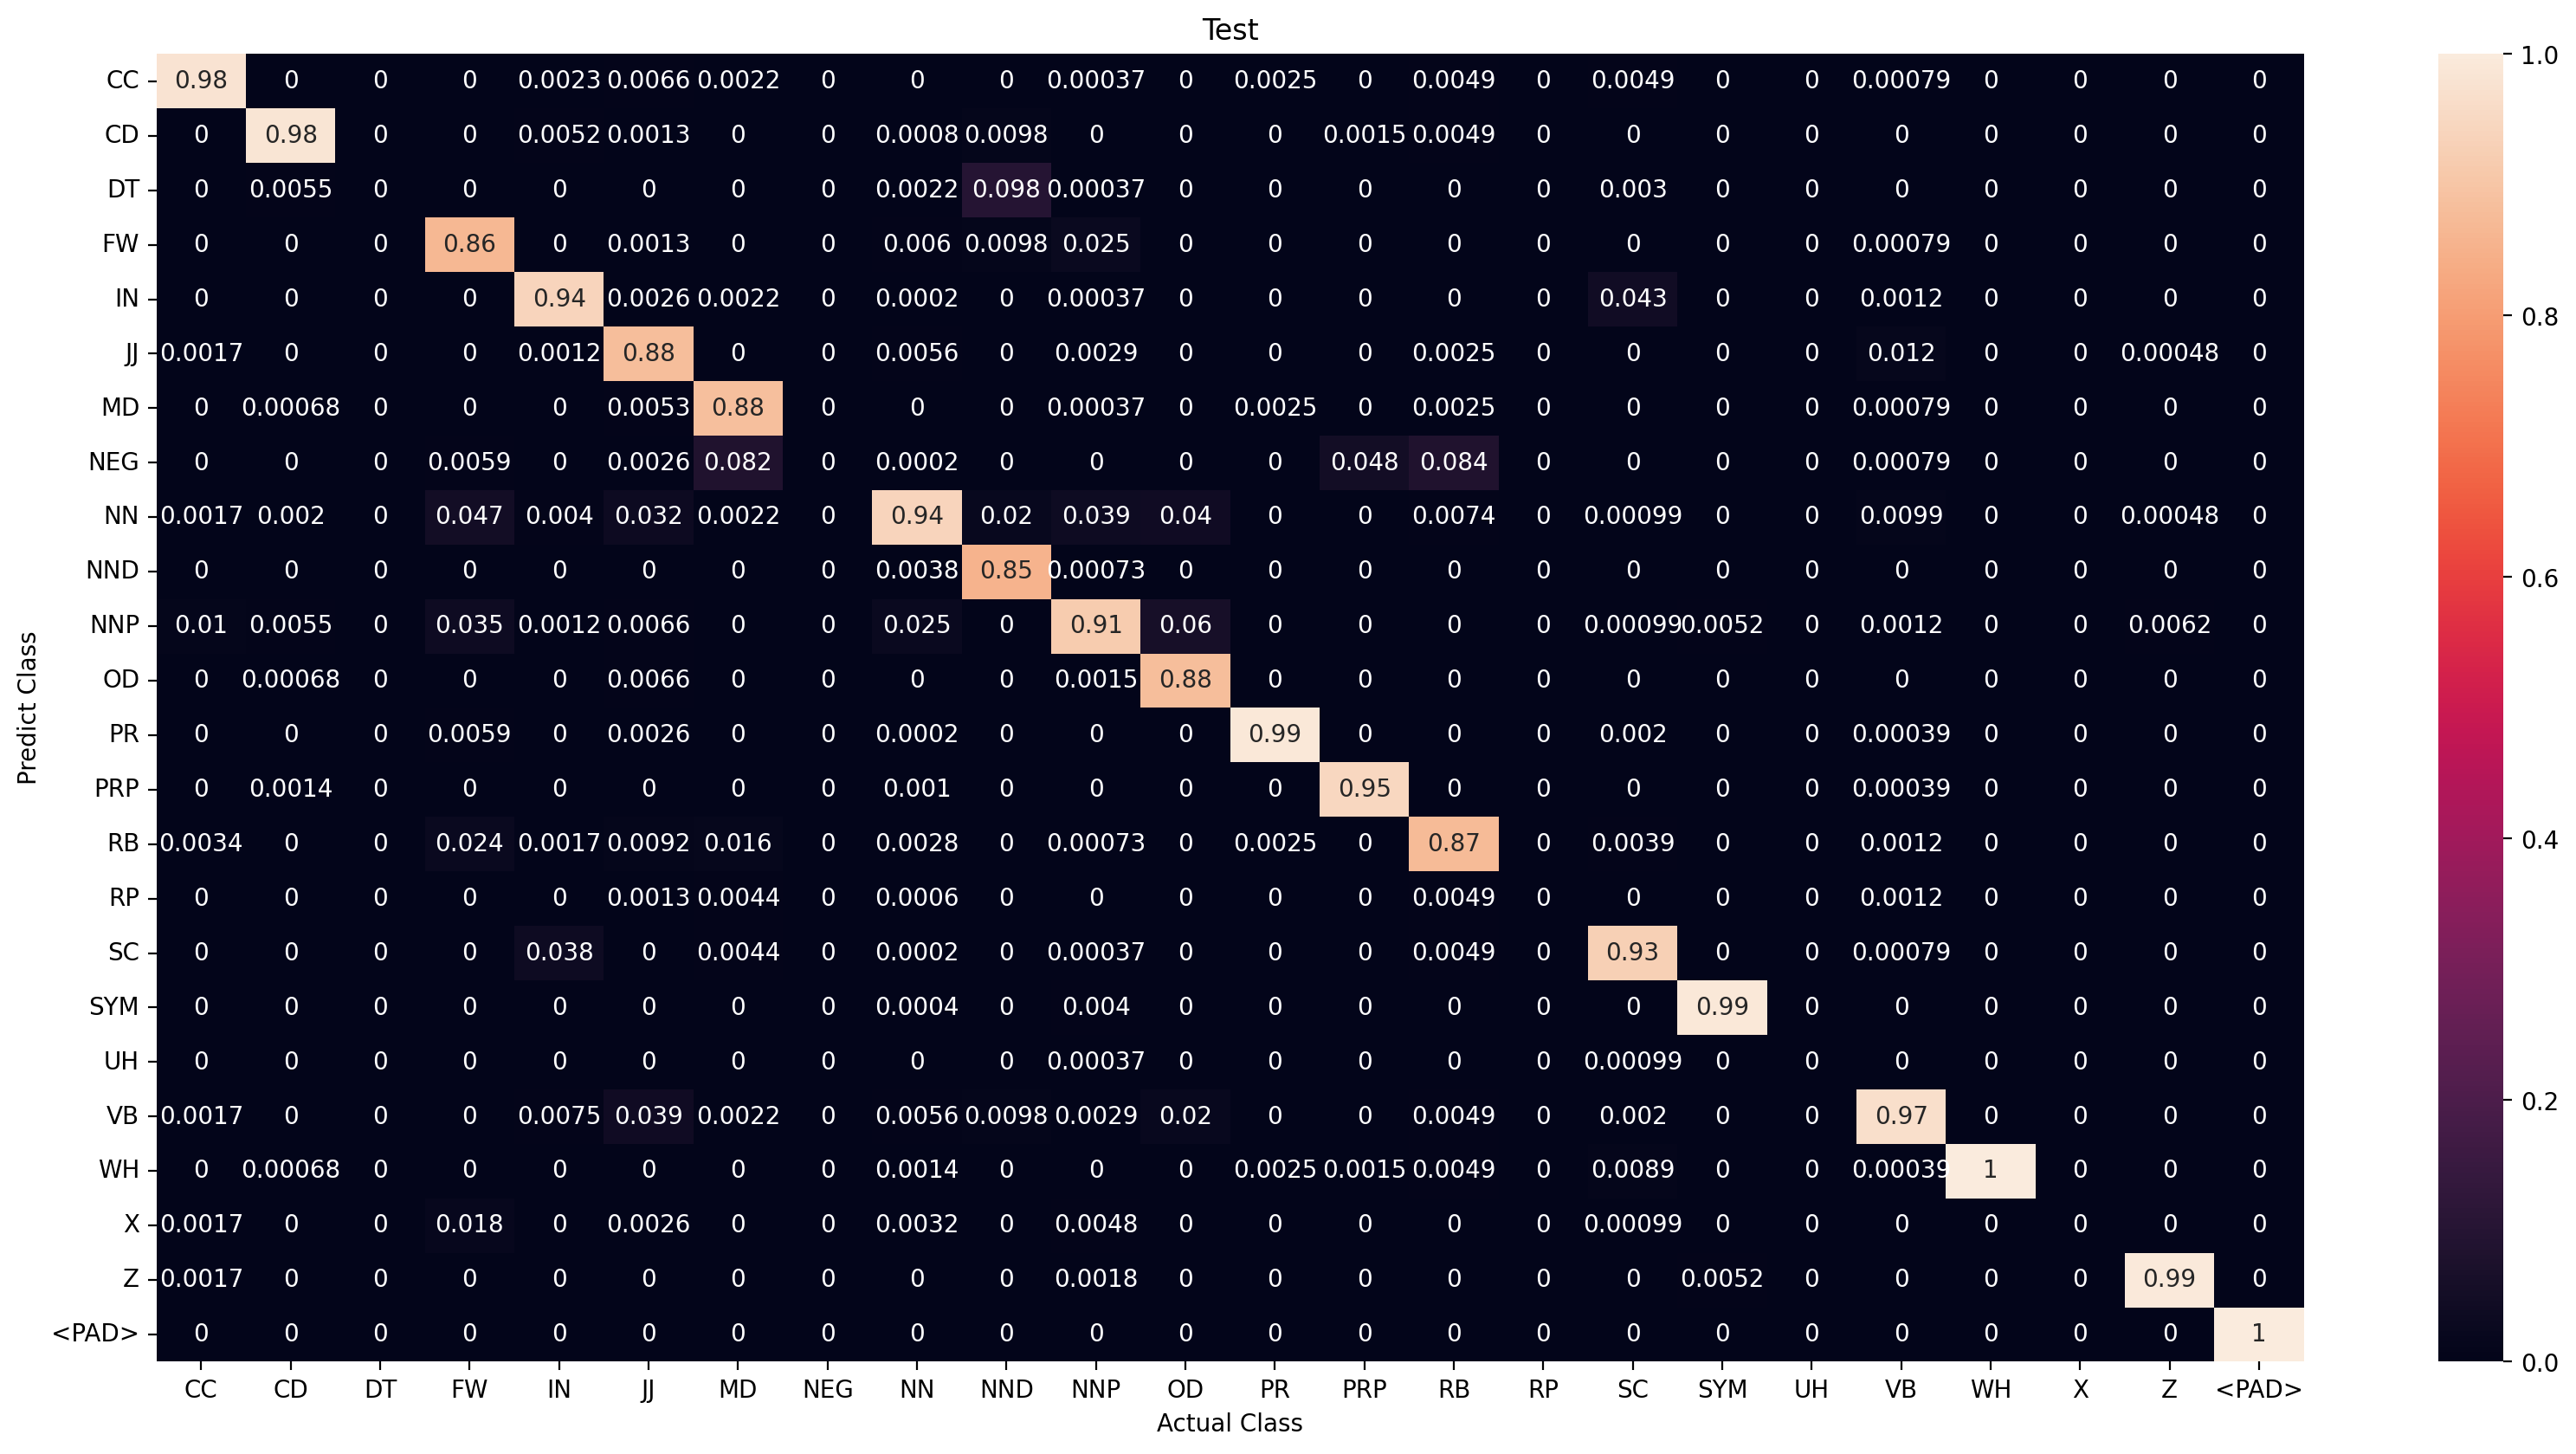

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5264       | CC    : 127      |
| CD    : 12882  | CD    : 12728      | CD    : 154      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1418       | FW    : 272      |
| IN    : 15403  | IN    : 15292      | IN    : 111      |
| JJ    : 7018   | JJ    : 6634       | JJ    : 384      |
| MD    : 3810   | MD    : 3688       | MD    : 122      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44164      | NN    : 564      |
| NND   : 1019   | NND   : 864        | NND   : 155      |
| NNP   : 24885  | NNP   : 24433      | NNP   : 452      |
| OD    : 534    | OD    : 503        | OD    : 31       |
| PR    : 3842   | PR    : 3798       | PR    : 44       |
| PRP   : 5405   | PRP   : 5360       | PRP   : 45       |
| RB    : 3553   | RB    : 3394       | RB    : 159      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11178
Wrong prediction            : 630
Percentage correct oov pred : 94.66463414634147

Validation
Number OOV token            : 3395
Correct prediction          : 3038
Wrong prediction            : 357
Percentage correct oov pred : 89.48453608247424

Test
Number OOV token            : 1359
Correct prediction          : 1209
Wrong prediction            : 150
Percentage correct oov pred : 88.96247240618102



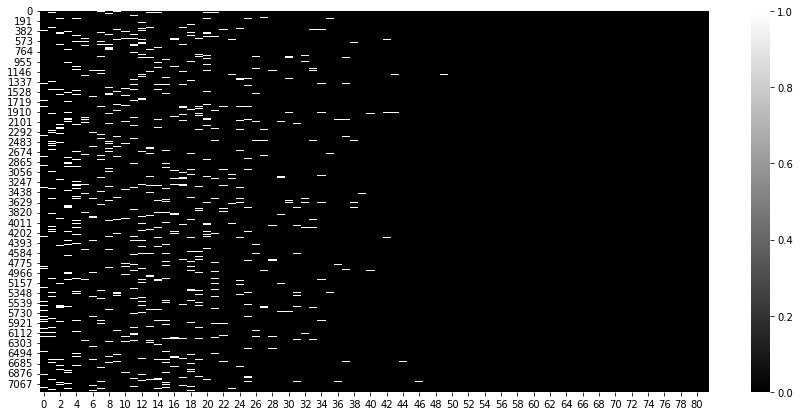

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

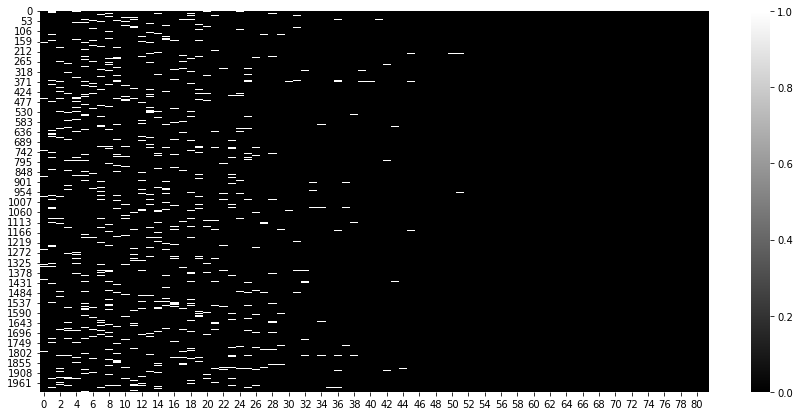

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

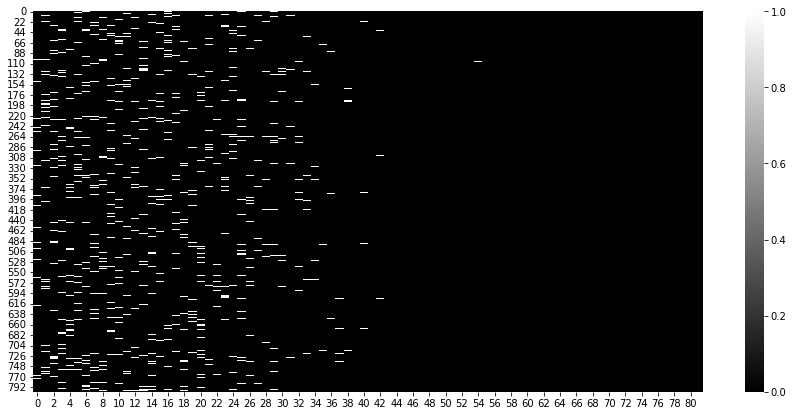

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);